In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [4]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Splitted training dataset(50,000 images) into 45,000 and 5,000 for training and validation

train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Apply different transform for valset (override)
valset.dataset.transform = test_transform

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Dataloaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader   = DataLoader(valset, batch_size=64, shuffle=False)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


In [15]:
lenet = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5),         # C1: 6x28x28
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),  # S2: 6x14x14

        nn.Conv2d(6, 16, kernel_size=5),        # C3: 16x10x10
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),  # S4: 16x5x5

        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),             # C5
        nn.Tanh(),
        nn.Linear(120, 84),                     # F6
        nn.Tanh(),
        nn.Linear(84, 10)                       # Output layer
    )

lenet = lenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

In [17]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=True, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [18]:
# Replace vgg19 → lenet wherever it appears

# Initialize early stopping
early_stopper = EarlyStopping(patience=3)

num_epochs = 10  # Max epochs (early stopping may cut it short)

for epoch in range(num_epochs):
    lenet.train()
    train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = lenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 🔍 Validation
    lenet.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lenet(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valloader)
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss/len(trainloader):.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {100 * val_correct / val_total:.2f}%")

    # ✅ Check for early stop
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print(f"\n⛔️ Stopping early at epoch {epoch+1} due to no improvement.")
        break


Epoch 1/10 | Train Loss: 1.0230 | Val Loss: 1.2682 | Val Acc: 55.52%
Epoch 2/10 | Train Loss: 0.9962 | Val Loss: 1.2905 | Val Acc: 55.16%
🛑 EarlyStopping counter: 1/3
Epoch 3/10 | Train Loss: 0.9725 | Val Loss: 1.3016 | Val Acc: 54.98%
🛑 EarlyStopping counter: 2/3
Epoch 4/10 | Train Loss: 0.9419 | Val Loss: 1.3101 | Val Acc: 55.42%
🛑 EarlyStopping counter: 3/3

⛔️ Stopping early at epoch 4 due to no improvement.


In [19]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, roc_auc_score,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


# ──────────────────────────────────────────────
# Helper: save figure then display inline
# ──────────────────────────────────────────────
def _save_and_show(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=300)
    plt.show()          # shows inline in Jupyter / Colab
    plt.close(fig)


def evaluate_model(model, dataloader, device, class_names,
                   save_dir="results", plot_pr_curve=False):
    """
    Evaluate the model, print metrics, and save+display plots.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    all_labels, all_preds, all_probs = [], [], []

    print("\n🔍 Evaluating the model...\n")
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(outputs.argmax(dim=1).cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    y_prob = np.concatenate(all_probs)

    # 1️⃣ Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    print(f"✅ Accuracy : {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall   : {rec:.4f}")
    print(f"✅ F1-Score : {f1:.4f}\n")

    # 2️⃣ Confusion-Matrix
    cm = confusion_matrix(y_true, y_pred)
    fig_cm, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig_cm.colorbar(im)
    _save_and_show(fig_cm, os.path.join(save_dir, "confusion_matrix.png"))

    # 3️⃣ ROC-AUC (OvA)
    y_onehot = label_binarize(y_true, classes=np.arange(len(class_names)))
    fig_roc, ax = plt.subplots()
    aucs = []
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_onehot[:, i], y_prob[:, i])
        auc = roc_auc_score(y_onehot[:, i], y_prob[:, i])
        aucs.append(auc)
        ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curves (One-vs-All)")
    ax.legend(loc="lower right")
    _save_and_show(fig_roc, os.path.join(save_dir, "roc_curves.png"))
    roc_auc_macro = np.mean(aucs)

    # 4️⃣ Precision-Recall (optional)
    pr_auc_macro = None
    if plot_pr_curve:
        fig_pr, ax = plt.subplots()
        aps = []
        for i, name in enumerate(class_names):
            prec_vals, rec_vals, _ = precision_recall_curve(
                y_onehot[:, i], y_prob[:, i])
            ap = average_precision_score(y_onehot[:, i], y_prob[:, i])
            aps.append(ap)
            ax.plot(rec_vals, prec_vals, label=f"{name} (AP={ap:.2f})")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("Precision-Recall Curves")
        ax.legend(loc="upper right")
        _save_and_show(fig_pr, os.path.join(save_dir, "pr_curves.png"))
        pr_auc_macro = np.mean(aps)

    print("\n📁 Plots saved to:", os.path.abspath(save_dir))

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc_macro": roc_auc_macro,
        "pr_auc_macro": pr_auc_macro
    }



🔍 Evaluating the model...



100%|██████████| 157/157 [00:04<00:00, 36.13it/s]


✅ Accuracy : 0.5526
✅ Precision: 0.5539
✅ Recall   : 0.5526
✅ F1-Score : 0.5514



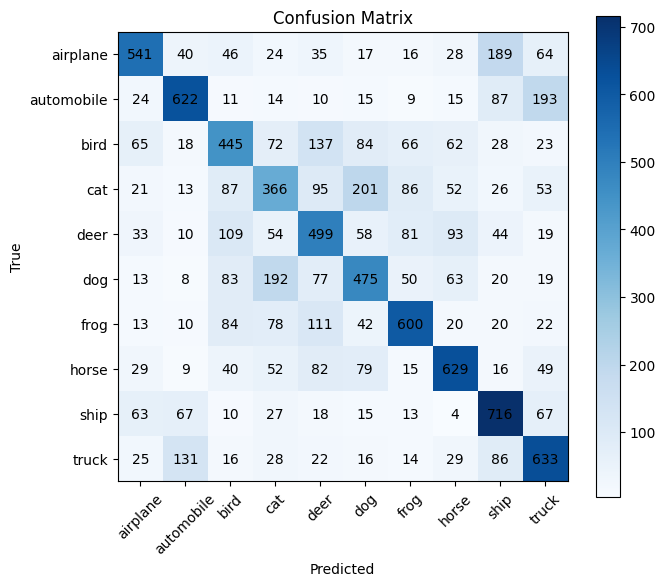

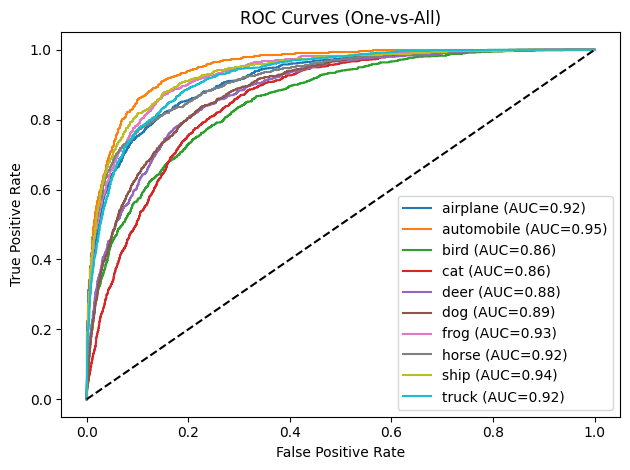

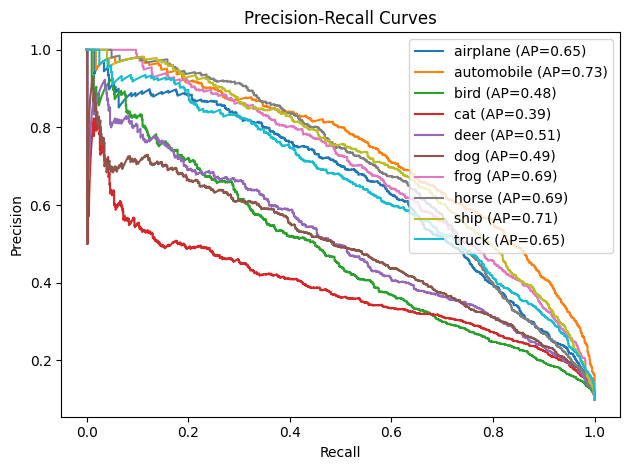


📁 Plots saved to: /content/lenet_eval_outputs

📊 Final metrics: {'accuracy': 0.5526, 'precision': 0.5538674649289795, 'recall': 0.5526000000000001, 'f1': 0.5513733595580893, 'roc_auc_macro': np.float64(0.905857611111111), 'pr_auc_macro': np.float64(0.5977213514973378)}


In [20]:
results = evaluate_model(
    model=lenet,
    dataloader=testloader,
    device=device,
    class_names=[
        "airplane","automobile","bird","cat","deer",
        "dog","frog","horse","ship","truck"
    ],
    save_dir="lenet_eval_outputs",
    plot_pr_curve=True
)

print("\n📊 Final metrics:", results)
